# Views and describes the data, before much processing.

In [1]:
#default_exp surveyors

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns
import plotnine as pn

#export
import restaurants_timeseries.core as core

In [4]:
#export
class VisitsSurveyor:
    def __init__(self, visits: core.pd.DataFrame, make_report: bool):
        self.make_report = make_report
        self.visits = visits
        self.assign_never_visited()
        self.filter_zero_periods()
        self.count_visited_days()
    
    def report(self, s: str):
        if self.make_report:
            if issubclass(type(s), core.pd.DataFrame):
                display(s)
            else:
                print(s)
        
    def assign_never_visited(self):        
        self.store_counts = self.visits.groupby('air_store_id').visitors.sum()
        self.never_visited = self.store_counts[self.store_counts == 0]
        self.report("The visits data looks like this:")
        self.report(self.visits.head())
        self.report(" ")        
        self.report(f"There are {len(self.store_counts)} stores.")
        self.report(f"{len(self.never_visited)} stores had no visits ever.")

    def filter_zero_periods(self):
        self.daily_total_visits = (
            self.visits
            [['visit_date', 'visitors']]
            .groupby('visit_date')
            .sum()
            .reset_index())
        earliest_day = self.daily_total_visits.query("visitors > 0").min().iloc[0]        
        latest_day = self.daily_total_visits.query("visitors > 0").max().iloc[0]
        self.visits = self.visits[
            (self.visits.visit_date >= earliest_day) &
            (self.visits.visit_date <= latest_day)]
        self.report(f"Populated data is from {earliest_day} to {latest_day}.")
        
    def count_visited_days(self):
        self.visited_days_counts = (
            self.visits[self.visits.visitors > 0].
            groupby('air_store_id')['visitors'].
            count().
            reset_index(name='days_visited'))
        if self.make_report:
            plt.figure(figsize=(8, 4))
            (sns.histplot(data=self.visited_days_counts['days_visited']).
             set(title="How many stores were visited e.g. 300+ times?",
                 xlabel="days with at least 1 visit", ylabel="stores"))

The visits data looks like this:


,air_store_id,air_genre_name,air_area_name,latitude,longitude,visit_date,day_of_week,holiday_flg,visitors
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,2016-01-01,Friday,1,0
1,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,2016-01-02,Saturday,1,0
2,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,2016-01-03,Sunday,1,0
3,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,2016-01-04,Monday,0,0
4,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,2016-01-05,Tuesday,0,0


 
There are 829 stores.
0 stores had no visits ever.
Populated data is from 2016-01-01 to 2017-04-22.


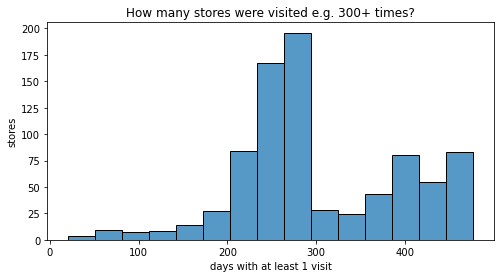

In [5]:
vs = VisitsSurveyor(core.data['visits'], True)

In [6]:
#export
vs = VisitsSurveyor(core.data['visits'], False)
populated_store_id = vs.visited_days_counts.sort_values(by='days_visited', ascending=False).air_store_id[0]

In [7]:
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_view_data.ipynb.
Converted 02_model_one.ipynb.
Converted index.ipynb.
